In [1]:
from transformer_lens import HookedTransformer
import transformer_lens
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import transformer_lens.utils as utils
import hashlib
import yaml 
import hashlib
import pickle
import numpy as np
import matplotlib.pyplot as plt 

/root/mech_interp_research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

In [3]:
device = utils.get_device()

reference_model_path = 'meta-llama/Llama-3.1-8B'
baseline_model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

baseline_model_hf = AutoModelForCausalLM.from_pretrained(baseline_model_path, torch_dtype=torch.bfloat16)
baseline_model_tokenizer = AutoTokenizer.from_pretrained(baseline_model_path)

baseline_model = HookedTransformer.from_pretrained_no_processing(
    reference_model_path,
    hf_model=baseline_model_hf,
    tokenizer=baseline_model_tokenizer,
    device=device,
    move_to_device=True,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [4]:
model=baseline_model

In [5]:
chat = [
  {"role": "user", "content": "What's the fifth prime?"},
]

In [6]:
model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False)

"<｜begin▁of▁sentence｜><｜User｜>What's the fifth prime?<｜Assistant｜><think>\n"

In [7]:
model.tokenizer.apply_chat_template(chat, add_generation_prompt=True)

[128000, 128011, 3923, 596, 279, 18172, 10461, 30, 128012, 128013, 198]

In [8]:
output = model.generate(
    model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False),
    max_new_tokens=50,
    do_sample=False,
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 12.84it/s]


In [9]:
print(output)

<｜User｜>What's the fifth prime?<｜Assistant｜><think>
To determine the fifth prime number, I'll start by listing the prime numbers in order.

First, I know that 2 is the first prime number.

Next, 3 is also a prime number since it has no divisors other than 1


In [10]:
logits = model(
    model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False),
    return_type='logits',
)
print(logits.shape)

torch.Size([1, 12, 128256])


In [11]:
probs = logits[0, -1, :].softmax(dim=-1)

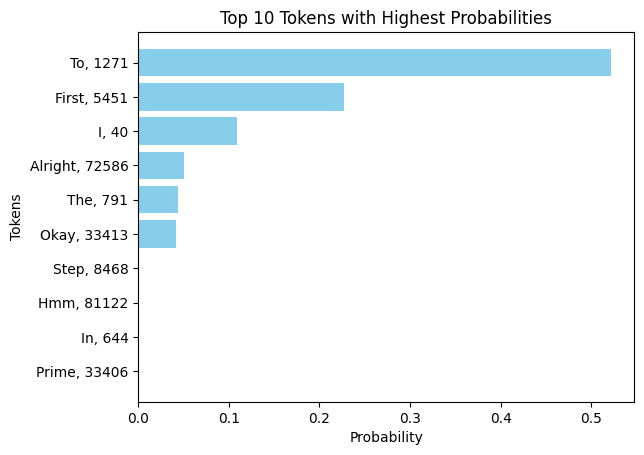

In [12]:
# Assuming `probs` is a tensor of probabilities and `model.tokenizer` is defined
topk = 10  # Number of top tokens to visualize
topk_probs, topk_indices = probs.topk(topk)  # Get top-k probabilities and their indices

# Decode the token indices to get the corresponding tokens
topk_tokens = [f"{model.tokenizer.decode([idx])}, {idx}" for idx in topk_indices]

# Convert tensors to numpy arrays for visualization
topk_probs = topk_probs.cpu().detach().numpy()
topk_indices = topk_indices.cpu().detach().numpy()

# Plot the bar chart
import matplotlib.pyplot as plt

plt.barh(topk_tokens, topk_probs, color='skyblue')
plt.xlabel('Probability')
plt.ylabel('Tokens')
plt.title('Top 10 Tokens with Highest Probabilities')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest probability at the top
plt.show()

### creating answering metric 

we'll take a set of different reasoning prompts 

In [13]:
import random
import re

def sample_prompts(filepath="mds/reasoning-prompts.md", n=1, seed=None):
    """
    Samples n prompts randomly from a markdown file.

    Args:
        filepath (str): Path to the markdown file.
        n (int): Number of prompts to sample.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        List of sampled prompts as strings (without leading numbers).
    """
    if seed is not None:
        random.seed(seed)

    with open(filepath, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract prompts: assume prompts are numbered like '1. ', '2. ', etc.
    prompts = []
    for line in lines:
        line = line.strip()
        if line and line[0].isdigit():
            # Remove the leading number and period using regex
            prompt = re.sub(r'^\d+\.\s*', '', line)
            prompts.append(prompt)

    if n > len(prompts):
        raise ValueError(f"Requested {n} prompts, but only {len(prompts)} available.")

    return random.sample(prompts, n)


In [14]:
samples = sample_prompts(filepath="mds/reasoning-prompts.md", n=50, seed=1)

In [15]:
tot_probs = None

for sample in samples:
    print(sample)
    chat = [
        {"role": "user", "content": sample},
    ]

    output = model(model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False), return_type='logits')
    probs = output[0, -1, :].softmax(dim=-1)
    if tot_probs is None:
        tot_probs = probs
    else:
        tot_probs += probs
tot_probs /= len(samples)
topk = 10  # Number of top tokens to visualize



If a store sells 3 pens for $2.40, how much will 7 pens cost?


Which country was the first to industrialize?
What is the main function of the liver?
What is the process of converting light energy into chemical energy in plants?
What is the difference between an acid and a base?
If 20% of a number is 35, what is the number?
What is the antonym of "brave"?
If 2x + 3y = 12 and x = 3, what is y?
Who was the first president of the United States?
What causes the seasons on Earth?
What does the idiom "beat around the bush" mean?
What is the difference between "lay" and "lie"?
What event marked the beginning of the Great Depression?
Identify the alliteration in: "Peter Piper picked a peck of pickled peppers."
What is the smallest unit of an element?
What is the median of the numbers: 12, 7, 15, 9, 21?
If the ratio of boys to girls in a class is 3:5 and there are 24 students total, how many boys are in the class?
Which civilization built the pyramids in Egypt?
What is the sum of the first 10 integers?
What causes the phases of the Moon?
What is the law of 

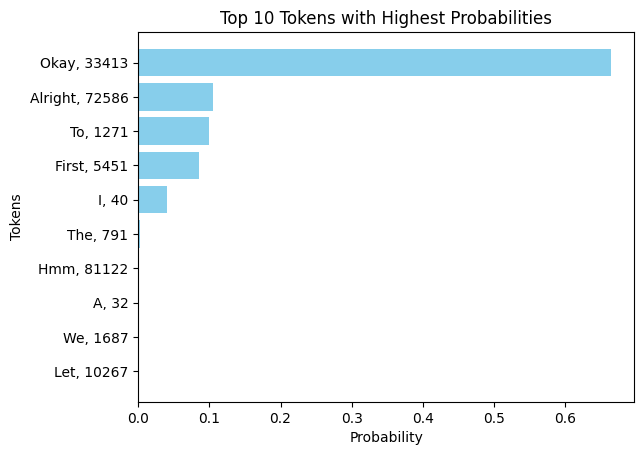

In [16]:
# now plots the topk tokens
topk_probs, topk_indices = tot_probs.topk(topk)  # Get top-k probabilities and their indices
# Decode the token indices to get the corresponding tokens
topk_tokens = [f"{model.tokenizer.decode([idx])}, {idx}" for idx in topk_indices]
# Convert tensors to numpy arrays for visualization
topk_probs = topk_probs.cpu().detach().numpy()
topk_indices = topk_indices.cpu().detach().numpy()
# Plot the bar chart
plt.barh(topk_tokens, topk_probs, color='skyblue')
plt.xlabel('Probability')
plt.ylabel('Tokens')
plt.title('Top 10 Tokens with Highest Probabilities')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest probability at the top
plt.show()

now we'll take prompts and generate up to the top think token

# Note 

it looks like the style of reasoning vs answering is very prompt specific 

why don't I just examine the style of a specific prompt, and construct a prompt specific metric 

In [ ]:
import torch
import torch.nn.functional as F
from transformer_lens import HookedTransformer
from typing import List, Tuple, Dict

class ReasoningAnsweringComparator:
    def __init__(
        self,
        ref_model: HookedTransformer,
        tokenizer,
        chat: List[Dict[str,str]],
        eos_token: str = "</think>",
        topk: int = 10,
    ):
        """
        ref_model: the “reference” HookedTransformer you want to measure against
        tokenizer: same tokenizer used by ref_model
        chat:      [{"role":"user","content":"..."}] style prompt
        eos_token: the token string marking end of think, e.g. "</think>"
        topk:      how many top probs to store
        """
        self.tokenizer = tokenizer
        self.eos_token_id = tokenizer.encode(eos_token)[0]
        self.topk = topk

        # build the raw strings
        self.think_prefix =  tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False)
        # generate greedily up to and including </think>
        self.answer_prefix = self._greedy_think_generation(ref_model, self.think_prefix)

        # now stash the reference distributions
        self.think_ids,  self.think_p = self._get_topk(ref_model, self.think_prefix)
        self.ans_ids,    self.ans_p   = self._get_topk(ref_model, self.answer_prefix)

    def _greedy_think_generation(self, model: HookedTransformer, prefix: str) -> str:
        """Run greedy decode until </think> and return prefix+generated_text."""
        out = model.generate(
            prefix,
            max_new_tokens=500,
            do_sample=False,
            eos_token_id=self.eos_token_id
        )
        assert out[-len("</think>"):]=='</think>'
        return out  # already includes prefix + generated think tokens

    def _get_topk(
        self,
        model: HookedTransformer,
        text: str
    ) -> Tuple[List[int], List[float]]:
        """Compute the top-k next-token ids+probs after feeding in `text`."""
        ids = torch.tensor([self.tokenizer.encode(text)], device=model.cfg.device)
        logits = model.run_with_cache(ids, return_type="logits")  # shape [1, L, V]
        last = logits[0, -1]                                        # [V]
        probs = last.softmax(-1)
        p_vals, tok = torch.topk(probs, self.topk)
        return tok.tolist(), p_vals.tolist()

    def compare_model(self, other_model: HookedTransformer) -> Dict[str, float]:
        """
        For another HookedTransformer, recompute both distributions,
        compute cross-entropy to the reference distributions, and return:
          { "CE_think": ..., "CE_answer": ..., "Delta": CE_answer - CE_think }
        """
        # get new probs for the *same* token sets
        def gather_probs(model, ids):
            # forward pass
            # we just need next‐token logits after the same prefix
            # so pick correct prefix based on ids origin
            ctx = self.think_prefix if ids is self.think_ids else self.answer_prefix
            _, p = self._get_topk(model, ctx)  # p is a list aligned to ids
            return torch.tensor(p, device=model.cfg.device)

        new_think_p = gather_probs(other_model, self.think_ids)
        new_ans_p   = gather_probs(other_model, self.ans_ids)

        ref_think_p = torch.tensor(self.think_p, device=new_think_p.device)
        ref_ans_p   = torch.tensor(self.ans_p,   device=new_ans_p.device)

        # cross-entropy: CE(P_ref || P_new ) = - sum P_ref * log P_new
        ce_think = -torch.sum(ref_think_p * new_think_p.log()).item()
        ce_answer= -torch.sum(ref_ans_p   * new_ans_p.log()  ).item()
        return {
            "CE_think": ce_think,
            "CE_answer": ce_answer,
            "Delta": ce_answer - ce_think
        }


 34%|███▍      | 88/256 [00:06<00:12, 13.54it/s]


KeyboardInterrupt: 

In [28]:
chat = [
  {"role": "user", "content": "What's the fifth prime?"},
]

In [32]:
model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False)

'<｜begin▁of▁sentence｜><｜User｜>What event marked the beginning of the Great Depression?<｜Assistant｜><think>\n'

In [29]:
test_output = model.generate(
    model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False),
    max_new_tokens=256,
    do_sample=False,
    eos_token_id=128014
)

  0%|          | 0/256 [00:00<?, ?it/s]

 59%|█████▊    | 150/256 [00:11<00:07, 13.54it/s]


In [30]:
print(test_output)

<｜User｜>What's the fifth prime?<｜Assistant｜><think>
To determine the fifth prime number, I'll start by listing the prime numbers in order.

First, I know that 2 is the first prime number.

Next, 3 is also a prime number since it has no divisors other than 1 and itself.

Then, 4 is not a prime number because it can be divided by 2.

Following that, 5 is a prime number as it has no divisors other than 1 and 5.

After 5, 6 is not a prime number because it can be divided by 2 and 3.

Next, 7 is a prime number with no divisors other than 1 and 7.

Finally, 11 is the fifth prime number in the sequence.
</think>


In [23]:
model.to_tokens("</think>")

tensor([[128000, 128014]], device='cuda:0')

In [24]:
model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False)

'<｜begin▁of▁sentence｜><｜User｜>If the diagonal of a square is 8√2 cm, what is the area of the square?<｜Assistant｜><think>\n'

In [18]:
props2 = output[0, -1, :].softmax(dim=-1)

In [19]:
type(props2)

torch.Tensor

In [20]:
props2.topk(10)

torch.return_types.topk(
values=tensor([5.1210e-01, 2.5772e-01, 1.0982e-01, 7.5115e-02, 2.2997e-02, 9.0958e-03,
        5.1384e-03, 8.5943e-04, 7.4983e-04, 5.0942e-04], device='cuda:0'),
indices=tensor([33413, 72586,  1271,  5451,    40, 81122,   791, 10267,    32, 11839],
       device='cuda:0'))

In [21]:
output

tensor([[[ 1.1601,  2.0860,  4.8631,  ..., -1.1549, -1.1549, -1.1549],
         [ 1.1601,  2.0860,  4.8631,  ..., -1.1549, -1.1549, -1.1549],
         [ 7.2881,  2.2454,  1.0443,  ..., -3.8254, -3.8254, -3.8258],
         ...,
         [ 2.1971, -2.1198, -4.2101,  ...,  2.0578,  2.0576,  2.0580],
         [ 3.6799,  5.7603,  5.6633,  ..., -2.0983, -2.0983, -2.0980],
         [ 4.1453,  7.5314,  8.6311,  ..., -2.1035, -2.1038, -2.1036]]],
       device='cuda:0')

In [22]:
jhg

NameError: name 'jhg' is not defined

Note: 

to do this rigorously 

compute probabilities over N (16, 32 prompts)

and use the outputs over those 
this controls for different output probabilities between different prompts 

look at variance between prmopts to make sure that your metrics 



In [ ]:
pos_features = [[1271], [1271, 1505], [1271, 8417], [334, 37942, 25]]
neg_features = [[33413]]

In [ ]:
model.to_string(neg_features[0])

'Okay'

In [ ]:
for feat in pos_features:
    print(model.to_string(feat))

To
To find
To determine
**Solution:


write a function which takes in a list of lists of tokens 

promtp = "do this"

eg: 
pos_features = [
    [12,],
    [13, 128]
]

negative_feats = [...]

log_prob(pos_feats) - log_prob(prompt+neg_feats) 


appends each to the end of a prompt, and returns their

In [ ]:

def compute_feature_mode_metric(
    model: HookedTransformer,
    prompt: str,
    pos_features: list[list[int]],
    neg_features: list[list[int]],
):
    """
    Computes:
      - normalized probabilities for each feature sequence (sum to 1)
      - unnormalized log-scores for each
      - logit (log-odds) of producing any negative feature.
    Uses model.to_tokens() for tokenization.
    """
    device = model.cfg.device
    # 1) Tokenize prompt with the built-in hook
    #    (adds BOS if the model is configured to)
    input_ids = model.to_tokens(prompt).to(device)

    # 2) Score one feature sequence by accumulating log-probs
    def sequence_score(feature: list[int]) -> torch.Tensor:
        ctx = input_ids.clone()
        total_log_prob = torch.tensor(0.0, device=device)
        for tok in feature:
            # run the model on the current context
            logits, activations = model.run_with_cache(ctx) #turn off this 
            last_logits = logits[:, -1, :]  # [1, vocab_size]
            log_probs = torch.log_softmax(last_logits, dim=-1)
            total_log_prob = total_log_prob + log_probs[0, tok]
            # append the ground-truth token to the context
            ctx = torch.cat([ctx, torch.tensor([[tok]], device=device)], dim=1)
        return total_log_prob

    # 3) Compute scores for all features
    all_features = pos_features + neg_features
    scores = torch.stack([sequence_score(f) for f in all_features])  # (n+m,)

    # 4) Softmax to get normalized probabilities
    norm_probs = torch.softmax(scores, dim=0)                        # (n+m,)

    # 5) Sum up the negative-feature mass & compute logit
    num_pos   = len(pos_features)
    neg_prob  = norm_probs[num_pos:].sum()
    neg_logit = torch.log(neg_prob) - torch.log(1 - neg_prob)

    return norm_probs, scores, neg_logit




In [ ]:
pos_features = [[1271], [1271, 1505], [1271, 8417], [334, 37942, 25]]
neg_features = [[33413]]

for pf in pos_features:
    print(model.to_string(pf))

print("\n\n")

for nf in neg_features:
    print(model.to_string(nf))

To
To find
To determine
**Solution:



Okay


In [ ]:

prompt       = "<｜User｜>What is 8/4<｜Assistant｜><think>\n"
pos_features = [[1271], [1271, 1505], [1271, 8417], [334, 37942, 25]]
neg_features = [[33413]]

norm_probs, scores, neg_logit = compute_feature_mode_metric(
    model, prompt, pos_features, neg_features
)

print("Normalized probabilities:", norm_probs)
print("Unnormalized log-scores:", scores)
print("Negative-feature logit:", neg_logit)

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 44.34 GiB of which 24.81 MiB is free. Process 2410955 has 44.31 GiB memory in use. Of the allocated memory 43.97 GiB is allocated by PyTorch, and 32.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

prompt       = "<｜User｜>What is 8/4<｜Assistant｜><think>\nOkay, I know 8/4=2\n</think>s"
pos_features = [[1271], [1271, 1505], [1271, 8417], [334, 37942, 25]]
neg_features = [[33413]]

norm_probs, scores, neg_logit = compute_feature_mode_metric(
    model, prompt, pos_features, neg_features
)

print("Normalized probabilities:", norm_probs)
print("Unnormalized log-scores:", scores)
print("Negative-feature logit:", neg_logit)